In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [ ]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [ ]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

**Data description:**  
Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.  

Data is from https://archive.ics.uci.edu/dataset/2/adult

*Disclaimer* numbers below for Neural Networks, etc are outdated, so do not orient on these

**Task:** - download the dataset in python and load it here. Check the dataset size and preliminary artifacts.  

*Hint:*
* How many unique values the target column should have?

In [ ]:
# TODO - download the dataset

!pip install ucimlrepo


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets
data = pd.concat([X,y], axis=1)


# shapes
print('shape of features:', X.shape)
print('shape of targets:', y.shape)
#print('shape of dataset:', adult.shape)

# metadata
print(adult.metadata)

# variable information
print(adult.variables)


shape of features: (48842, 14)
shape of targets: (48842, 1)
{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Mon Aug 07 2023', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': 'Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean

In [ ]:
target_column = 'income'
test_size = 0.2
random_state = 42

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity. Sometimes, even the fact that data is missing could be data itself (think about patients who came or missed doctor appointment). In this case we are going with the most simple way to handle Nans - basically removing such entries.*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 40 items.

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Encode categorical values**   

Use label encodings for categorical variables

*Hint:*
* To make t easier to drop rows with nan values, merge $X$ and $Y$ in the same dataframe

In [ ]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans
    '''
    # TODO
    df=df.dropna()

    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical
    if it has <= n unique values
    '''
    for col in df.columns:
        if col not in ignore:
            if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() <= n:
                df[col] = df[col].astype('category')
    return df


def remove_columns_by_n(df, condition, n=10, direction='less',
                        ignore=[target_column]):
    '''

    Remove columns with more or less than n unique values.
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    # TODO
    columns_to_drop = []

    for col in df.columns:
        if col not in ignore and (df[col].dtype == condition):
            unique_values_count = df[col].nunique()
            if (direction == 'less' and unique_values_count < n) or (direction == 'more' and unique_values_count > n):
                columns_to_drop.append(col)

    df = df.drop(columns=columns_to_drop)
    return df

def object_to_categorical(df):
    '''
    Make columns with the 'object' type categorical
    and replace categories with label encodings
    '''
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
            df[col] = df[col].cat.codes # integers
    # TODO
    return df



In [ ]:
df = data
df = remove_nans(df)
df['income'] = df['income'].apply(lambda x: 0 if x.startswith('<') else 1)
df = remove_columns_by_n(df, n=40, direction='more', condition="category",
                         ignore=[target_column])
df = numerical_to_categorical(df, n=2, ignore=[target_column])

df = remove_columns_by_n(df, n=10, direction='less', condition=np.float64,
                         ignore=[target_column])
df = remove_columns_by_n(df, n=10, direction='less', condition=np.int64,
                         ignore=[target_column])
df = object_to_categorical(df)

assert not df.isna().any().any(), 'There are still nans in the dataframe'

<ipython-input-7-365b9c19cdb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['income'] = df['income'].apply(lambda x: 0 if x.startswith('<') else 1)


In [ ]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,4,245211,9,13,4,10,3,4,1,0,0,40,39,0
48837,39,4,215419,9,13,0,10,1,4,0,0,0,36,39,0
48839,38,4,374983,9,13,2,10,0,4,1,0,0,50,39,0
48840,44,4,83891,9,13,0,1,3,1,1,5455,0,40,39,0


In [ ]:
unique_values = df['income'].unique()
print(unique_values) # binarised
df["income"].value_counts() # we see an imbalance: more samples with less or equal 50k -> stratify

[0 1]


income
0    36080
1    11541
Name: count, dtype: int64

In [ ]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(target_column, axis=1)
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)

In [ ]:
# Dimension before - after
print(data.shape)
print(df.shape)

(48842, 15)
(47621, 15)


**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the target variable?



*   We split the dataset in a stratified manner following the distribution of the target variable. We have about 36k samples earning less or equal to 50k and only about 11k samples earning more. To keep this proportion, we split in a stratified manner. Otherwise it may occur that we have even more extreme imbalance in test or training set. E.g. only 10% 1's in training set -> model will likely not be able to predict 1's very accurately in test set
*   No columns were deleted, but through NA removal we went from 48842 rows to 47621 rows
*   Originally, there were 4 unique categorical variables "<=50K, <=50K., >50K, >50K." However, I accumulated the variables if the only difference was the point after the K. Therefore we have 2 categorical variables which we could easily binarize.



## Task 1: Create a GradientBoostingClassifier

In [ ]:
## TODO : define the GradientBoostingClassifier,
## train it on the train set and predict on the test set
gradboost = GradientBoostingClassifier()
gradboost.fit(train_X,train_y)
predictions = gradboost.predict(test_X)

In [ ]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics
print(f"Accuracy: {accuracy_score(test_y,predictions)}")
print(f"Precision: {precision_score(test_y,predictions)}") # ability of the classifier not to label as positive a sample that is negative.
print(f"Recall: {recall_score(test_y,predictions)}") #the ability of the classifier to find all the positive samples.

Accuracy: 0.8640419947506561
Precision: 0.7876206700738216
Recall: 0.6009532062391681


In [ ]:
## TODO : Write a function which iterates over trees_amount,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    results = {'trees_amount': [], 'accuracy': [], 'precision': [], 'recall': []}

    for i in trees_amount:
        gradboost = GradientBoostingClassifier(n_estimators=i)
        gradboost.fit(train_X, train_y)
        predictions = gradboost.predict(test_X)
        results['trees_amount'].append(i)
        results['accuracy'].append(accuracy_score(test_y, predictions))
        results['precision'].append(precision_score(test_y, predictions))
        results['recall'].append(recall_score(test_y, predictions))

    return pd.DataFrame(results)


In [ ]:
trees_amount_exploration(train_X, train_y, test_X, test_y)
# Warning indicates that with only 1 tree it happens that the predictions never predict one class -> likely Overfitting model that only
# predicts the majority class tp / (tp + fp)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,trees_amount,accuracy,precision,recall
0,1,0.757690,0.000000,0.000000
1,20,0.844199,0.788515,0.487868
2,50,0.858793,0.800374,0.555893
3,100,0.864042,0.787621,0.600953


In [ ]:
## TODO : Write a function which iterates over the learning rate,
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    results = {'learning_rates': [], 'accuracy': [], 'precision': [], 'recall': []}

    for i in learning_rates:
        gradboost = GradientBoostingClassifier(learning_rate=i, n_estimators=trees_amount)
        gradboost.fit(train_X, train_y)
        predictions = gradboost.predict(test_X)
        results['learning_rates'].append(i)
        results['accuracy'].append(accuracy_score(test_y, predictions))
        results['precision'].append(precision_score(test_y, predictions))
        results['recall'].append(recall_score(test_y, predictions))

    return pd.DataFrame(results)


In [ ]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

,learning_rates,accuracy,precision,recall
0,0.1,0.864042,0.787621,0.600953
1,0.2,0.871076,0.792524,0.633882
2,0.3,0.873806,0.793836,0.647314
3,0.4,0.874751,0.792651,0.654246
4,0.5,0.872756,0.786911,0.651213


In [ ]:
## TODO : Write a function which iterates over different depths,
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    results = {'depth': [], 'accuracy': [], 'precision': [], 'recall': []}

    for i in depths:
        gradboost = GradientBoostingClassifier(max_depth=i, n_estimators=50)
        gradboost.fit(train_X, train_y)
        predictions = gradboost.predict(test_X)
        results['depth'].append(i)
        results['accuracy'].append(accuracy_score(test_y, predictions))
        results['precision'].append(precision_score(test_y, predictions))
        results['recall'].append(recall_score(test_y, predictions))

    return pd.DataFrame(results)


In [ ]:
max_depth_exploration(train_X, train_y, test_X, test_y)

,depth,accuracy,precision,recall
0,1,0.834016,0.841957,0.387782
1,2,0.851759,0.800671,0.516898
2,3,0.858793,0.800374,0.555893
3,5,0.866562,0.791784,0.609619


**TODO :**   

* How does the max_depth parameter influence the results?
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?



*   Accuracy is increasing with depth (at least for depth 1-5), precision is decreasing, recall is increasing.
*   Learning rate has highest impact on recall with bigger increase. Accuracy and precision stay similar
*   n of trees positively influences all metrics
*   Look below for answer



In [ ]:
import itertools

def all_exploration(train_X, train_y, test_X, test_y, n, lr, depths=[1,2,3,5]):
    results = {'depth': [], 'n': [], 'lr': [], 'accuracy': [], 'precision': [], 'recall': []}

    for depth, n_val, lr_val in itertools.product(depths, n, lr):
        gradboost = GradientBoostingClassifier(max_depth=depth, n_estimators=n_val, learning_rate=lr_val)
        gradboost.fit(train_X, train_y)
        predictions = gradboost.predict(test_X)
        results['depth'].append(depth)
        results['n'].append(n_val)
        results['lr'].append(lr_val)
        results['accuracy'].append(accuracy_score(test_y, predictions))
        results['precision'].append(precision_score(test_y, predictions))
        results['recall'].append(recall_score(test_y, predictions))

    return pd.DataFrame(results)


In [ ]:
all = all_exploration(train_X, train_y, test_X, test_y, n=[5,50,100,200], lr=[0.05,0.2,0.5,1], depths=[2,5,7,10])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

In [ ]:
print(all.sort_values(by='accuracy', ascending=False).iloc[0])  # highest acc
print(all.sort_values(by='precision', ascending=False).iloc[0])  # highest precision
print(all.sort_values(by='recall', ascending=False).iloc[0])  # highest recall

# The model with the highest accuracy has a depth of 7, 200 trees, and lr of 0.05
# The model with the highest precision has a depth of 10, 5 trees, and a lr of 0.2
# The model with the highest recall has a depth of 7, 50 trees and a lr of 1

depth          7.000000
n            200.000000
lr             0.050000
accuracy       0.877690
precision      0.799371
recall         0.661179
Name: 44, dtype: float64
depth        10.000000
n             5.000000
lr            0.200000
accuracy      0.856483
precision     0.849814
recall        0.495234
Name: 49, dtype: float64
depth         7.000000
n            50.000000
lr            1.000000
accuracy      0.849869
precision     0.701007
recall        0.663345
Name: 39, dtype: float64


In [ ]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    importance = clf.feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    sorted_idx = importance.argsort()[::-1]
    sorted_importance = importance[sorted_idx]
    sorted_feature_names = feature_names[sorted_idx]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), sorted_importance, align='center')
    plt.yticks(range(len(sorted_idx)), sorted_feature_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.show()

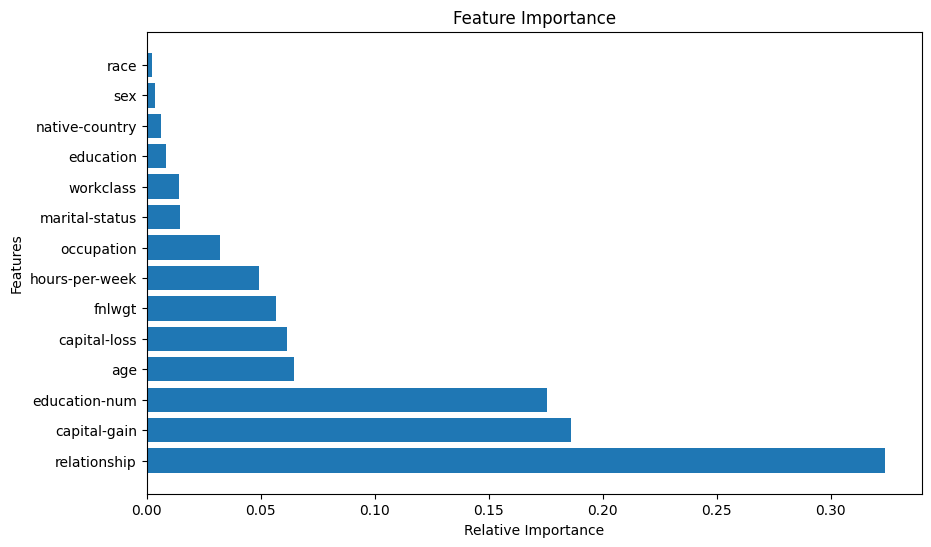

In [ ]:
## TODO : display the plot
gradboost = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.5)
gradboost.fit(train_X,train_y)
plot_explained_variance(gradboost,X)


Highest importance for relationship variable as well as capital gain and educational years. Less importance for variables that would potentially indicate  discrimination such as sex or race.

## Prepare for deep learning
### Add all the necessary training functions
*You can reuse them from previous practical exercises*

In [ ]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3

def accuracy(correct, total):
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    acc = correct/total
    return acc


In [ ]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    train_losses = 0.0
    correct_predictions = 0
    total_predictions = 0
    model.train()
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        # move
        inputs.to(device)
        labels.to(device)

        #Forward pass
        prediction = model.forward(inputs)
        #print(prediction[0,:])
        loss = loss_fn(prediction, labels)
        train_losses += loss.item()

        #Calculate accuracy
        max_value, index_max_value = torch.max(prediction,1)
        correct_predictions += torch.eq(index_max_value,labels).sum().item()
        total_predictions += inputs.size(0)

        #Backward pass
        loss.backward()
        optimizer.step()

    acc = accuracy(correct_predictions, total_predictions)
    train_losses = train_losses/len(dataloader)

    return train_losses, acc


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    val_losses = 0.0
    correct_predictions = 0
    total_predictions = 0
    #model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs.to(device)
            labels.to(device)
            predictions = model.forward(inputs)
            loss = loss_fn(predictions, labels)
            val_losses += loss.item()

            #Calculate accuracy
            max_value, index_max_value = torch.max(predictions,1)
            correct_predictions += torch.eq(index_max_value,labels).sum().item()
            total_predictions += inputs.size(0)

    val_losses = val_losses/len(dataloader)
    acc = accuracy(correct_predictions, total_predictions)
    return val_losses, acc

In [ ]:
#TODO write a run_training function that
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # Reset model
    for param in model.parameters():
        if param.requires_grad:
            param.data.uniform_(-0.1, 0.1)

    master_bar = trange(num_epochs, desc="Epoch", unit="epoch")


    for epoch in master_bar:
        #Train
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print("Epoch done")

    return train_losses, train_accs, val_losses, val_accs

In [ ]:
# TODO write a plot_model_progress function
## It should plot epochs vs metric progress
## Hint - you can use yours from practical 2 or 3
def plot_model_progress(train, val, category):
    plt.figure(figsize=(8, 8))
    x = np.arange(1,31)

    # Plot training losses
    plt.plot(x, train, label='Training', color='blue')
    # Plot validation losses
    plt.plot(x, val, '--', label='Validation', color='blue')

    # Adding titles and labels
    plt.title(f'Training and Validation {category}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{category}')
    plt.legend(fontsize=8)

    # Show plot
    plt.show()


### Convert a pandas dataframe to a PyTorch dataset

In [ ]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes,
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        self.x = df_x.to_numpy()
        self.y = df_y.to_numpy()
        self.mean = mean
        self.std = std
        self.normalise = normalise

    def __len__(self):
        # TODO: return the length of the whole dataset
        return len(self.x)

    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        data = self.x[index]
        if self.normalise and self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std
        return data, self.y[index]

In [ ]:
print(train_X.shape)
print(test_X.shape)

(38096, 14)
(9525, 14)


In [ ]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical
## Hint : the response variable should be of datatype integer
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)
train_y = train_y.astype(np.int64)
test_y = test_y.astype(np.int64)


In [ ]:
mean = train_X.mean(axis=0).values
std = train_X.std(axis=0).values

In [ ]:
unique_values = train_y.unique()
print(unique_values)

[0 1]


In [ ]:
test_X.shape

(9525, 14)

In [ ]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0! -> they already do
new_train = TabularDataset(train_X, train_y, mean=mean, std=std, normalise=True)
new_test = TabularDataset(test_X, test_y, mean=mean, std=std, normalise=True)

## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(new_train, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(new_test, batch_size=batch_size, shuffle=True)


## Logistic regression

In [ ]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?

        #print('x_shape:',x.shape)
        x = x.to(torch.float32)
        # TODO run the data through the layer
        #print(self.linear.weight.dtype)
        #print(x.dtype)
        x = x.view(-1, input_dim)
        outputs = self.linear(x)

        return outputs

In [ ]:
## TODO define model, loss and optimizers
## don't forget to move everything for the correct devices
##
lr=0.001

# get input dim
train_batch, label_batch = next(iter(train_dataloader))
input_dim = np.prod(train_batch[0].shape) # product
output_dim = 2

# model
model = LR(input_dim, output_dim)
#model.to(device) # funktioniert wieder nicht


# loss
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
## TODO train the network
num_epochs = 30
train_losses, train_accs, val_losses, val_accs = run_training(model,
                                                              optimizer, loss_function, device, num_epochs, train_dataloader, test_dataloader)

Epoch:   3%|▎         | 1/30 [00:00<00:20,  1.39epoch/s]

Epoch done


Epoch:   7%|▋         | 2/30 [00:01<00:18,  1.55epoch/s]

Epoch done


Epoch:  10%|█         | 3/30 [00:02<00:18,  1.50epoch/s]

Epoch done


Epoch:  13%|█▎        | 4/30 [00:02<00:17,  1.49epoch/s]

Epoch done


Epoch:  17%|█▋        | 5/30 [00:03<00:17,  1.40epoch/s]

Epoch done


Epoch:  20%|██        | 6/30 [00:03<00:15,  1.55epoch/s]

Epoch done


Epoch:  23%|██▎       | 7/30 [00:04<00:13,  1.72epoch/s]

Epoch done


Epoch:  27%|██▋       | 8/30 [00:04<00:11,  1.85epoch/s]

Epoch done


Epoch:  30%|███       | 9/30 [00:05<00:10,  1.94epoch/s]

Epoch done


Epoch:  33%|███▎      | 10/30 [00:05<00:10,  1.98epoch/s]

Epoch done


Epoch:  37%|███▋      | 11/30 [00:06<00:09,  2.02epoch/s]

Epoch done


Epoch:  40%|████      | 12/30 [00:06<00:08,  2.08epoch/s]

Epoch done


Epoch:  43%|████▎     | 13/30 [00:07<00:08,  2.11epoch/s]

Epoch done


Epoch:  47%|████▋     | 14/30 [00:07<00:07,  2.15epoch/s]

Epoch done


Epoch:  50%|█████     | 15/30 [00:08<00:06,  2.14epoch/s]

Epoch done


Epoch:  53%|█████▎    | 16/30 [00:08<00:06,  2.16epoch/s]

Epoch done


Epoch:  57%|█████▋    | 17/30 [00:09<00:06,  2.13epoch/s]

Epoch done


Epoch:  60%|██████    | 18/30 [00:09<00:05,  2.15epoch/s]

Epoch done


Epoch:  63%|██████▎   | 19/30 [00:09<00:05,  2.15epoch/s]

Epoch done


Epoch:  67%|██████▋   | 20/30 [00:10<00:04,  2.16epoch/s]

Epoch done


Epoch:  70%|███████   | 21/30 [00:10<00:04,  2.17epoch/s]

Epoch done


Epoch:  73%|███████▎  | 22/30 [00:11<00:03,  2.15epoch/s]

Epoch done


Epoch:  77%|███████▋  | 23/30 [00:11<00:03,  2.15epoch/s]

Epoch done


Epoch:  80%|████████  | 24/30 [00:12<00:02,  2.13epoch/s]

Epoch done


Epoch:  83%|████████▎ | 25/30 [00:12<00:02,  2.15epoch/s]

Epoch done


Epoch:  87%|████████▋ | 26/30 [00:13<00:01,  2.15epoch/s]

Epoch done


Epoch:  90%|█████████ | 27/30 [00:13<00:01,  2.11epoch/s]

Epoch done


Epoch:  93%|█████████▎| 28/30 [00:14<00:01,  1.86epoch/s]

Epoch done


Epoch:  97%|█████████▋| 29/30 [00:15<00:00,  1.73epoch/s]

Epoch done


Epoch: 100%|██████████| 30/30 [00:15<00:00,  1.90epoch/s]

Epoch done


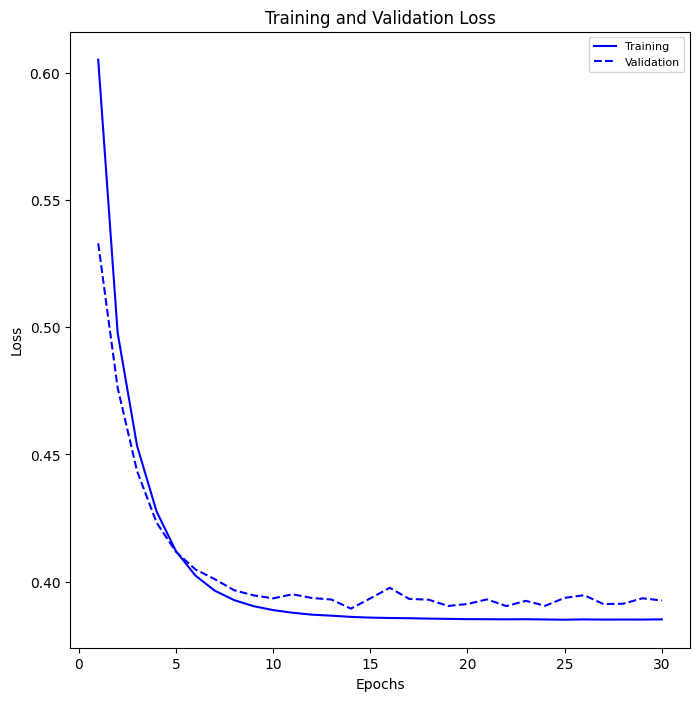

In [ ]:
## todo - plot epochs vs loss with plot_model_progress
plot_model_progress(train_losses, val_losses, "Loss")

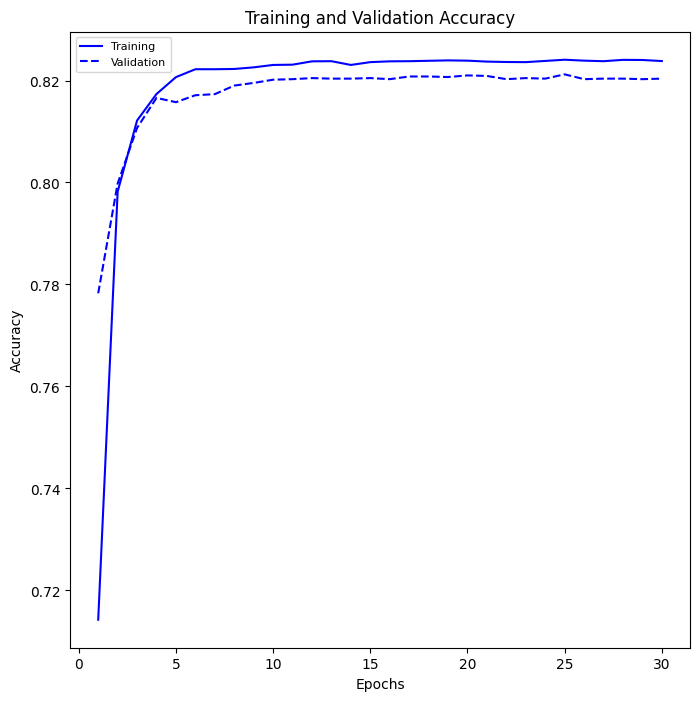

In [ ]:
## todo - plot epochs and accuracy with plot_model_progress
plot_model_progress(train_accs, val_accs, "Accuracy")


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

Convolutions make mainly sense on image data because they are able to detect patterns like edges, textures and shapes. Tabular data does not have any of these. Also image data usually have higher dimensional structure, which is ideal for convoultions but tabular data is usually 1d. MLP on the other hand would anyway require flattening data to 1d so it is well suited for tabular data as it does not assume any spatial relationships

In [ ]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
            nn.Linear(input_dim // 4, output_dim)
        )


    def forward(self, x):
        """ Defines the computation performed at every call. """
        # TODO
        x = x.float()
        return self.network(x).float()

In [ ]:
import torch.optim as optim


In [ ]:
## TODO : define model, optimizer, cross entropy loss,
## put model to the device, and train mode
## you can optionally try to add regularization
lr=0.001
loss_fn = nn.CrossEntropyLoss()
MLP = TabularNetwork(input_dim, output_dim)
optimizer = optim.Adam(MLP.parameters(), lr=lr)
#MLP.to(device)
MLP.train()

TabularNetwork(
  (network): Sequential(
    (0): Linear(in_features=14, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [ ]:
## TODO : Train model
num_epochs = 30
train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp = run_training(MLP,
                                                              optimizer, loss_fn, device, num_epochs, train_dataloader, test_dataloader)

Epoch:   3%|▎         | 1/30 [00:00<00:17,  1.68epoch/s]

Epoch done


Epoch:   7%|▋         | 2/30 [00:01<00:15,  1.79epoch/s]

Epoch done


Epoch:  10%|█         | 3/30 [00:01<00:14,  1.86epoch/s]

Epoch done


Epoch:  13%|█▎        | 4/30 [00:02<00:13,  1.89epoch/s]

Epoch done


Epoch:  17%|█▋        | 5/30 [00:02<00:13,  1.91epoch/s]

Epoch done


Epoch:  20%|██        | 6/30 [00:03<00:12,  1.92epoch/s]

Epoch done


Epoch:  23%|██▎       | 7/30 [00:03<00:11,  1.92epoch/s]

Epoch done


Epoch:  27%|██▋       | 8/30 [00:04<00:11,  1.91epoch/s]

Epoch done


Epoch:  30%|███       | 9/30 [00:04<00:10,  1.92epoch/s]

Epoch done


Epoch:  33%|███▎      | 10/30 [00:05<00:10,  1.92epoch/s]

Epoch done


Epoch:  37%|███▋      | 11/30 [00:05<00:09,  1.93epoch/s]

Epoch done


Epoch:  40%|████      | 12/30 [00:06<00:09,  1.93epoch/s]

Epoch done


Epoch:  43%|████▎     | 13/30 [00:06<00:08,  1.94epoch/s]

Epoch done


Epoch:  47%|████▋     | 14/30 [00:07<00:08,  1.94epoch/s]

Epoch done


Epoch:  50%|█████     | 15/30 [00:07<00:07,  1.95epoch/s]

Epoch done


Epoch:  53%|█████▎    | 16/30 [00:08<00:07,  1.93epoch/s]

Epoch done


Epoch:  57%|█████▋    | 17/30 [00:08<00:06,  1.94epoch/s]

Epoch done


Epoch:  60%|██████    | 18/30 [00:09<00:06,  1.93epoch/s]

Epoch done


Epoch:  63%|██████▎   | 19/30 [00:09<00:05,  1.90epoch/s]

Epoch done


Epoch:  67%|██████▋   | 20/30 [00:10<00:05,  1.73epoch/s]

Epoch done


Epoch:  70%|███████   | 21/30 [00:11<00:05,  1.57epoch/s]

Epoch done


Epoch:  73%|███████▎  | 22/30 [00:12<00:05,  1.44epoch/s]

Epoch done


Epoch:  77%|███████▋  | 23/30 [00:13<00:05,  1.37epoch/s]

Epoch done


Epoch:  80%|████████  | 24/30 [00:13<00:04,  1.44epoch/s]

Epoch done


Epoch:  83%|████████▎ | 25/30 [00:14<00:03,  1.56epoch/s]

Epoch done


Epoch:  87%|████████▋ | 26/30 [00:14<00:02,  1.66epoch/s]

Epoch done


Epoch:  90%|█████████ | 27/30 [00:15<00:01,  1.72epoch/s]

Epoch done


Epoch:  93%|█████████▎| 28/30 [00:15<00:01,  1.77epoch/s]

Epoch done


Epoch:  97%|█████████▋| 29/30 [00:16<00:00,  1.80epoch/s]

Epoch done


Epoch: 100%|██████████| 30/30 [00:16<00:00,  1.79epoch/s]

Epoch done


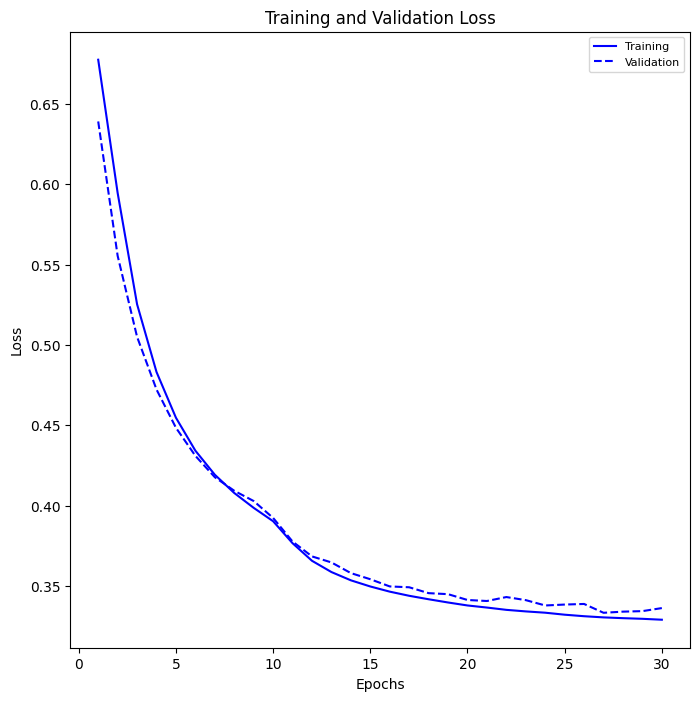

In [ ]:
## todo - plot epochs vs loss with plot_model_progress
plot_model_progress(train_losses_mlp, val_losses_mlp, "Loss")

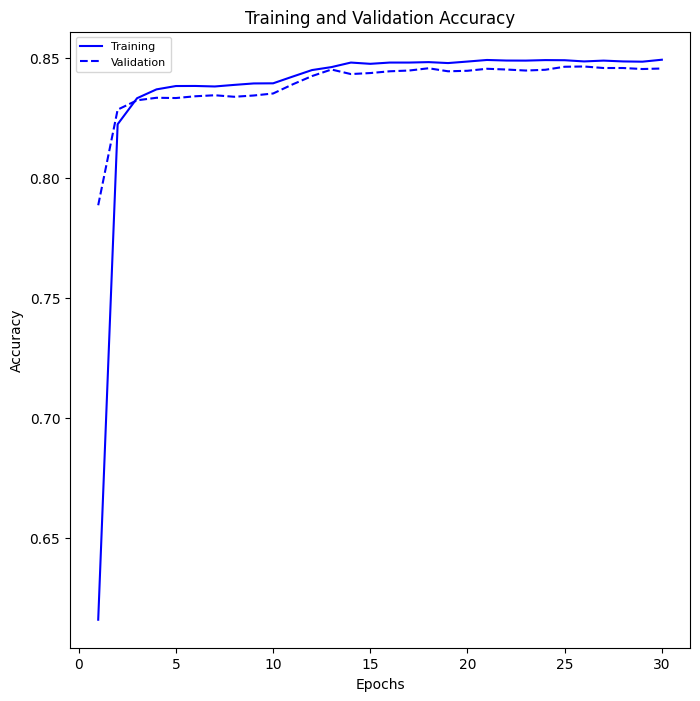

In [ ]:
## todo - plot epochs and accuracy with plot_model_progress
plot_model_progress(train_accs_mlp, val_accs_mlp, "Accuracy")

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why?


The GBC had a slightly higher accuracy than the MLP. One reason could be that we tuned the GBC, so we looked at different combinations of learning rate, depth and trees while we did not finetune the MLPs parameters like learning rate, batch size etc.

The loss decreased stronger in less epochs in the Logistic Regression compared to the MLP. However, overall the MLP had a smaller loss and a slightly higher accuracy. This could be for several reasons:
- MLPs can model more complex relationships so overall that may the reason for a smaller loss and higher accuracy
- The Logistic Regression maybe had a faster loss reduction initially because it may have quickly captured the most significant patterns but then failed to find the more complex ones
